In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from vision_transformer_pytorch import VisionTransformer

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
model.eval()

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/jinsukim/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
      (d

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Literal

def get_attention_map(img, get_mask=False):
    x = transform(img)
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)
    
def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal['mean', 'max', 'min']):
    # attentions : List which consist of [1, channels, height, width] size of attention data
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == 'mean':
                attention_heads_fused = attention.mean(axis = 1)
            elif head_fusion == 'max':
                attention_heads_fused = attention.max(axis = 1)[0]
            elif head_fusion == 'min':
                attention_heads_fused = attention.min(axis = 1)[0]
            
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention_heads_fused.size(-1))
            
            print("attention_heads_fused : ", attention_heads_fused.size())
            print("I : ", I.size())
            a = (attention_heads_fused + 1.0 * I) / 2.0
            a = a / a.sum(dim = -1)
            
            result = torch.matmul(a, result)

    mask = result[0,0,1:]
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width)
    mask = mask.numpy()
    mask = mask / np.max(mask)
    return mask

In [3]:
from PIL import Image

img = Image.open("./dataset/dur21_dis0/test/disruption/21325_1369_1390/0000.jpg")

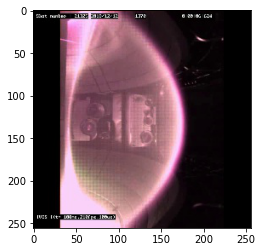

In [4]:
plt.imshow(img)

In [5]:
class VITAttentionRollout:
    def __init__(self, model : nn.Module, attention_layer_name = 'attn_drop', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        
        # for name, module in self.model.named_modules():
        #     for name_, module_ in module.named_children():
        #         if attention_layer_name in name_:
        #             module_.register_forward_hook(self.get_attention)
                    
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

x = transform(img).to(device).unsqueeze(0)
print("x : ", x.size())
model.to(device)

rollout_model = VITAttentionRollout(model)
att_mask = rollout_model(x)

x :  torch.Size([1, 3, 224, 224])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])
attention_heads_fused :  torch.Size([1, 197, 197])
I :  torch.Size([197, 197])


In [7]:
att_mask.shape

(14, 14)

In [8]:
rollout_model.attentions[-1].size()

torch.Size([1, 3, 197, 197])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


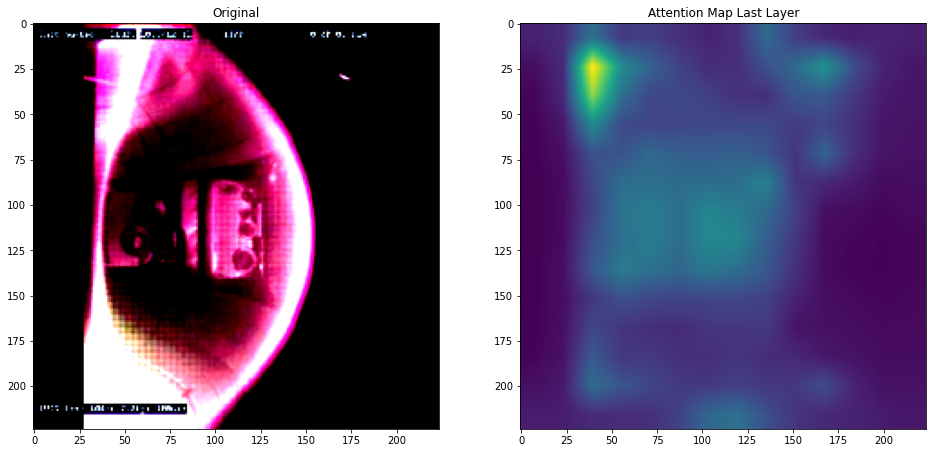

In [9]:
img = Image.open("./dataset/dur21_dis0/test/disruption/21325_1369_1390/0000.jpg")
img = transform(img).numpy()

def plot_attention_map(original_img, att_map):
    original_img = np.transpose(original_img, (1,2,0))
    att_map = cv2.resize(att_map, (224, 224))
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

plot_attention_map(img, att_mask)

In [70]:
from src.models.ViViT import ViViT

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

save_best_dir = "./weights/ViViT_clip_21_dist_0_best.pt"
model.load_state_dict(torch.load(save_best_dir))

for name, module in model.named_modules():
    for name_, module_ in module.named_children():
        if "to_out" in name_ and "space_transformer" in name:
            print("name : {}, name_ : {}".format(name, name_))

name : space_transformer.layers.0.0.fn, name_ : to_out
name : space_transformer.layers.1.0.fn, name_ : to_out
name : space_transformer.layers.2.0.fn, name_ : to_out
name : space_transformer.layers.3.0.fn, name_ : to_out


In [71]:
def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    result = result.repeat((21,1,1))
    
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (21, 1, 17, 17)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0).repeat((21,1,1))
            a = (attention_heads_fused + 1.0 * I) / 2.0
            
            result = torch.bmm(a, result)
            
    mask = result[:,0,1:]
    width = int(mask.size()[-1] ** 0.5)
    mask = mask.numpy().reshape(result.size()[0], width, width)
    mask = mask / np.max(mask)
    return mask

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "space_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
        # self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

from src.CustomDataset import CustomDataset
from torch.utils.data import DataLoader

train_data = CustomDataset(root_dir = "./dataset/dur21_dis0/", task = 'train', ts_data = None, augmentation = False, crop_size = 128, seq_len = 21, mode = 'video')
train_loader = DataLoader(train_data, batch_size = 1, sampler=None, num_workers = 8, pin_memory=False)

sample_data, sample_label = next(iter(train_loader))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
sample_data = sample_data.to(device)

rollout_model = ViViTAttentionRollout(model)
att_mask = rollout_model(sample_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


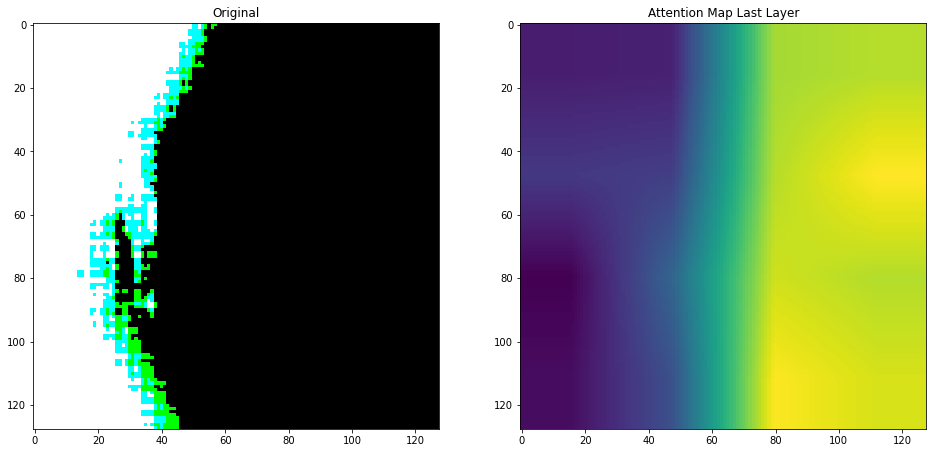

In [73]:
sample_data, sample_label = next(iter(train_loader))
sample_data = sample_data.to(device)

rollout_model = ViViTAttentionRollout(model)
att_mask = rollout_model(sample_data)

shot = sample_data.cpu().numpy()[0][:,-1,:,:]
shot = np.transpose(shot, (1,2,0))

att_map = cv2.resize(att_mask[-1], (128,128))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('Attention Map Last Layer')
_ = ax1.imshow(shot)
_ = ax2.imshow(att_map)

In [49]:
# what about temporal transformer

def rollout(attentions : List[torch.Tensor], discard_ratio : float, head_fusion : Literal["mean", 'max', 'min']):
    result = torch.eye(attentions[0].size()[-1]).unsqueeze(0)
    with torch.no_grad():
        for attention in attentions:
            
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # attention_heads_fused : (1, 22, 22)
            flat = attention_heads_fused.view(attention_heads_fused.size()[0], -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim = -1, largest = False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            
            I = torch.eye(attention.size(-1)).unsqueeze(0)
            a = (attention_heads_fused + 1.0 * I) / 2.0
            result = torch.bmm(a, result)
    
    mask = result[:,1:,1:].squeeze(0)
    mask = mask.numpy()
    mask = mask / np.max(mask)
    return mask

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class ViViTAttentionRollout:
    def __init__(self, model : nn.Module, layer_name = '0.fn.to_qkv', head_fusion = 'mean', discard_ratio = 0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
    
        for name, module in model.named_modules():
            if layer_name in name and "temporal_transformer" in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    
    def get_attention(self, module:nn.Module, input:torch.Tensor, output:torch.Tensor):
        
        h = self.model.n_heads
        output = torch.chunk(output, 3, -1)
        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), output)
        
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.model.d_head ** (-0.5)
        attn = torch.softmax(dots, dim = -1)
        self.attentions.append(attn.cpu())
        
    
    def __call__(self, input_tensor : torch.Tensor):
        self.attentions = []
        
        with torch.no_grad():
            output = self.model(input_tensor)
        
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

save_best_dir = "./weights/ViViT_clip_21_dist_3_best.pt"
model.load_state_dict(torch.load(save_best_dir))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
sample_data = sample_data.to(device)

rollout_model = ViViTAttentionRollout(model)
att_mask = rollout_model(sample_data)

/tmp/ipykernel_2039275/3382216630.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='vertical')


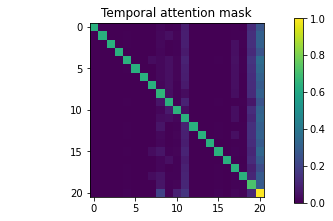

In [58]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Temporal attention mask')
plt.imshow(att_mask)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [25]:
df_vis.head()

,shot,year,tftsrt,tipminf,tTQend,dt,frame_cutoff,frame_tTQend,frame_tipminf
0,21273,2018,2.996,5.535,5.514,0.021,1165,1160,1164
1,21274,2018,2.996,10.056,10.038,0.018,2104,2100,2103
2,21310,2018,1.500,5.368,5.342,0.026,1131,1125,1130
3,21315,2018,1.500,7.804,7.782,0.022,1636,1631,1635
4,21317,2018,1.500,9.460,9.438,0.022,1980,1975,1979


/tmp/ipykernel_1005079/588395613.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


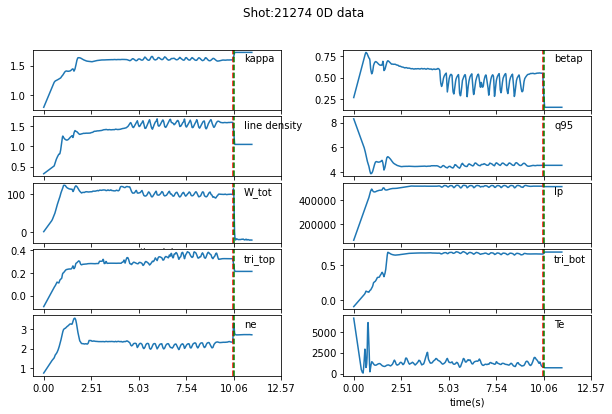

In [22]:
# shot num 21274
# plot 0D data with time axis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

save_dir = "./dataset/raw_videos/"
shot_num = 21274

df_ts = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv")
df_vis = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

ts_data_0D = df_ts[df_ts['shot'] == shot_num]

# 0D data upload
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd'] * (-1)
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

# thermal quench and current quench time
t_TQend = df_vis[df_vis.shot==shot_num]['tTQend'].values[0]
t_ipminf = df_vis[df_vis.shot==shot_num]['tipminf'].values[0]

fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (10,6), gridspec_kw={"wspace":0.25, "hspace":0.1},sharex = True)
ax_vis = axes[4,1].get_gridspec()
axs = axes.ravel()

fig.suptitle("Shot:{} 0D data".format(shot_num))
axs[0].plot(t, kappa, label = "kappa")
axs[0].text(0.85, 0.8, "kappa", transform = axs[0].transAxes)
axs[1].plot(t, betap, label = 'betap')
axs[1].text(0.85, 0.8, "betap", transform = axs[1].transAxes)
axs[2].plot(t, li, label = 'line density')
axs[2].text(0.85, 0.8, "line density", transform = axs[2].transAxes)
axs[3].plot(t, q95, label = 'q95')
axs[3].text(0.85, 0.8, "q95", transform = axs[3].transAxes)
axs[4].plot(t, W_tot, label = 'W_tot')
axs[4].text(0.85, 0.8, "W_tot", transform = axs[4].transAxes)
axs[5].plot(t, ip, label = 'Ip')
axs[5].text(0.85, 0.8, "Ip", transform = axs[5].transAxes)
axs[6].plot(t, tritop, label = 'tri_top')
axs[6].text(0.85, 0.8, "tri_top", transform = axs[6].transAxes)
axs[7].plot(t, tribot, label = 'tri_bot')
axs[7].text(0.85, 0.8, "tri_bot", transform = axs[7].transAxes)
axs[8].plot(t, ne, label = 'ne')
axs[8].text(0.85, 0.8, "ne", transform = axs[8].transAxes)
axs[9].plot(t, te, label = 'Te')
axs[9].text(0.85, 0.8, "Te", transform = axs[9].transAxes)

for idx in range(0,10):
    axs[idx].axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
    axs[idx].axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")

    if idx in [4,9]:
        quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
        t_quantile = [q * t_ipminf for q in quantile]
        axs[idx].set_xlabel("time(s)")
        axs[idx].set_xticks(t_quantile)
        axs[idx].set_xticklabels(["{:.2f}".format(t) for t in t_quantile])

fig.tight_layout()

/tmp/ipykernel_1005079/3061475515.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


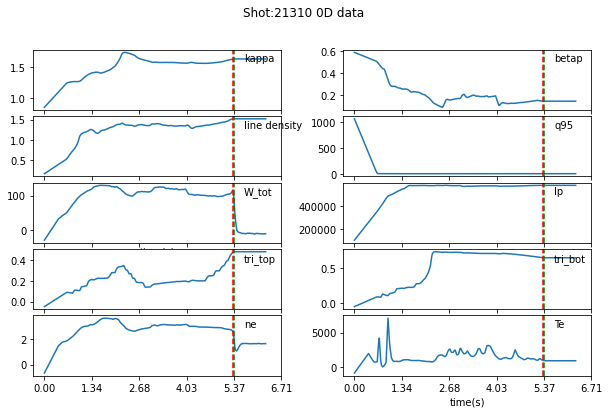

In [24]:
# shot num 21310
# plot 0D data with time axis

shot_num = 21310
ts_data_0D = df_ts[df_ts['shot'] == shot_num]

# 0D data upload
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd'] * (-1)
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

# thermal quench and current quench time
t_TQend = df_vis[df_vis.shot==shot_num]['tTQend'].values[0]
t_ipminf = df_vis[df_vis.shot==shot_num]['tipminf'].values[0]

fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (10,6), gridspec_kw={"wspace":0.25, "hspace":0.1},sharex = True)
ax_vis = axes[4,1].get_gridspec()
axs = axes.ravel()

fig.suptitle("Shot:{} 0D data".format(shot_num))
axs[0].plot(t, kappa, label = "kappa")
axs[0].text(0.85, 0.8, "kappa", transform = axs[0].transAxes)
axs[1].plot(t, betap, label = 'betap')
axs[1].text(0.85, 0.8, "betap", transform = axs[1].transAxes)
axs[2].plot(t, li, label = 'line density')
axs[2].text(0.85, 0.8, "line density", transform = axs[2].transAxes)
axs[3].plot(t, q95, label = 'q95')
axs[3].text(0.85, 0.8, "q95", transform = axs[3].transAxes)
axs[4].plot(t, W_tot, label = 'W_tot')
axs[4].text(0.85, 0.8, "W_tot", transform = axs[4].transAxes)
axs[5].plot(t, ip, label = 'Ip')
axs[5].text(0.85, 0.8, "Ip", transform = axs[5].transAxes)
axs[6].plot(t, tritop, label = 'tri_top')
axs[6].text(0.85, 0.8, "tri_top", transform = axs[6].transAxes)
axs[7].plot(t, tribot, label = 'tri_bot')
axs[7].text(0.85, 0.8, "tri_bot", transform = axs[7].transAxes)
axs[8].plot(t, ne, label = 'ne')
axs[8].text(0.85, 0.8, "ne", transform = axs[8].transAxes)
axs[9].plot(t, te, label = 'Te')
axs[9].text(0.85, 0.8, "Te", transform = axs[9].transAxes)

for idx in range(0,10):
    axs[idx].axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
    axs[idx].axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")

    if idx in [4,9]:
        quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
        t_quantile = [q * t_ipminf for q in quantile]
        axs[idx].set_xlabel("time(s)")
        axs[idx].set_xticks(t_quantile)
        axs[idx].set_xticklabels(["{:.2f}".format(t) for t in t_quantile])

fig.tight_layout()

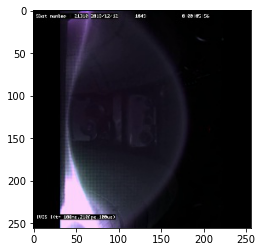

In [5]:
import cv2
import matplotlib.pyplot as plt

path = "./dataset/test-shot/00001048.jpg"
frame = cv2.imread(path)

plt.imshow(frame)